## 数据准备

In [6]:
import numpy as np
import pandas as pd

data = pd.read_csv('../data/data.csv')  # 读取数据
# 保留两位小数，并将结果保存为’.csv’文件
np.round(data.corr(method = 'pearson'), 2).to_csv('../tmp/data_cor.csv')
print('相关系数矩阵为：\n', np.round(data.corr(method = 'pearson'), 2))

相关系数矩阵为：
        x1    x2    x3    x4    x5    x6    x7    x8    x9   x10   x11   x12  \
x1   1.00  0.95  0.95  0.97  0.97  0.99  0.95  0.97  0.98  0.98 -0.29  0.94   
x2   0.95  1.00  1.00  0.99  0.99  0.92  0.99  0.99  0.98  0.98 -0.13  0.89   
x3   0.95  1.00  1.00  0.99  0.99  0.92  1.00  0.99  0.98  0.99 -0.15  0.89   
x4   0.97  0.99  0.99  1.00  1.00  0.95  0.99  1.00  0.99  1.00 -0.19  0.91   
x5   0.97  0.99  0.99  1.00  1.00  0.95  0.99  1.00  0.99  1.00 -0.18  0.90   
x6   0.99  0.92  0.92  0.95  0.95  1.00  0.93  0.95  0.97  0.96 -0.34  0.95   
x7   0.95  0.99  1.00  0.99  0.99  0.93  1.00  0.99  0.98  0.99 -0.15  0.89   
x8   0.97  0.99  0.99  1.00  1.00  0.95  0.99  1.00  0.99  1.00 -0.15  0.90   
x9   0.98  0.98  0.98  0.99  0.99  0.97  0.98  0.99  1.00  0.99 -0.23  0.91   
x10  0.98  0.98  0.99  1.00  1.00  0.96  0.99  1.00  0.99  1.00 -0.17  0.90   
x11 -0.29 -0.13 -0.15 -0.19 -0.18 -0.34 -0.15 -0.15 -0.23 -0.17  1.00 -0.43   
x12  0.94  0.89  0.89  0.91  0.90  0.95  0

## 特征工程

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso

data = pd.read_csv('../data/data.csv')  # 读取数据
# 调用Lasso()函数，设置λ的值为1000
lasso = Lasso(1000)
lasso.fit(data.iloc[:, 0:13], data['y'])
print('相关系数为：', np.round(lasso.coef_, 5))  # 输出结果，保留五位小数

print('相关系数非零个数为：', np.sum(lasso.coef_ != 0))  # 计算相关系数非零的个数

# 返回一个相关系数是否为零的布尔数组
mask = lasso.coef_ != 0
print('相关系数是否为零：', mask)

data = data.iloc[:, 0:13]
new_reg_data = data.iloc[:, mask]  # 返回相关系数非零的数据
new_reg_data.to_csv('../tmp/new_reg_data.csv')  # 存储数据
print('输出数据的维度为：', new_reg_data.shape)  # 查看输出数据的维度

相关系数为： [ -1.80000000e-04  -0.00000000e+00   1.24140000e-01  -1.03100000e-02
   6.54000000e-02   1.20000000e-04   3.17410000e-01   3.49000000e-02
  -0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.03000000e-02]
相关系数非零个数为： 8
相关系数是否为零： [ True False  True  True  True  True  True  True False False False False
  True]
输出数据的维度为： (20, 8)


D:\DELL\AppData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## 模型训练

In [8]:
# 自定义灰色预测函数 
def GM11(x0):  # x0为矩阵形式
    import numpy as np
    x1 = x0.cumsum()  # 1-AGO序列
    # 紧邻均值（MEAN）生成序列
    z1 = (x1[:len(x1) - 1] + x1[1:]) / 2.0
    z1 = z1.reshape((len(z1), 1))
    B = np.append(-z1, np.ones_like(z1), axis = 1)
    Yn = x0[1:].reshape((len(x0)-1, 1))
    # 计算参数
    [[a], [b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Yn) 
    # 还原值
    f = lambda k: (x0[0] - b / a) * np.exp(-a * (k - 1)) - (x0[0] - b / a) * np.exp(-a * (k - 2)) 
    delta = np.abs(x0 - np.array([f(i) for i in range(1, len(x0) + 1)]))
    C = delta.std() / x0.std()
    P = 1.0 * (np.abs(delta - delta.mean()) < 0.6745 * x0.std()).sum() / len(x0)
    # 返回灰色预测函数、a、b、首项、方差比、小残差概率
    return f, a, b, x0[0], C, P

In [9]:
import pandas as pd
import numpy as np

new_reg_data = pd.read_csv('../tmp/new_reg_data.csv')  # 读取经过特征选择后的数据
data = pd.read_csv('../data/data.csv')  # 读取总的数据
new_reg_data.index = range(1994, 2014)
new_reg_data.loc[2014] = None
new_reg_data.loc[2015] = None
Accuracy = []  # 存放灰色预测模型精度
l = ['x1', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x13']
for i in l:
    f = GM11(new_reg_data.loc[range(1994, 2014), i].as_matrix())[0]
    new_reg_data.loc[2014, i] = f(len(new_reg_data) - 1)  # 2014年预测结果
    new_reg_data.loc[2015, i] = f(len(new_reg_data))  # 2015年预测结果
    new_reg_data[i] = new_reg_data[i].round(2)  # 保留两位小数
    C = GM11(new_reg_data.loc[range(1994, 2014), 'x1'].as_matrix())[4]
    P = GM11(new_reg_data.loc[range(1994, 2014), 'x1'].as_matrix())[5]
    if P>0.95 and C<0.35:
        Accuracy.append('好')
    elif 0.8<P<=0.95 and 0.35<=C<0.5:
        Accuracy.append('合格')
    elif 0.7<P<=0.8 and 0.5<=C<0.65:
        Accuracy.append('勉强合格')
    else :
        Accuracy.append('不合格')

new_reg_data = new_reg_data.iloc[:, 1:]
new_reg_data.loc['模型精度', :] = Accuracy
outputfile = '../tmp/new_reg_data_GM11.xls'  # 灰色预测后保存的路径
# 提取财政收入列，合并至新数据框中
y = list(data['y'].values)
y.extend([np.nan, np.nan])
new_reg_data.loc[range(1994, 2016),'y'] = y
new_reg_data.to_excel(outputfile)  # 结果输出
# 预测结果展示
print('预测结果为：\n', new_reg_data.loc[[2014, 2015, '模型精度'], :])

预测结果为：
                x1       x3       x4       x5           x6       x7       x8  \
2014  8.14215e+06  7042.31  43611.8  35046.6  8.50552e+06   4600.4  18686.3   
2015  8.46049e+06  8166.92  47792.2  38384.2  8.62714e+06  5214.78  21474.5   
模型精度            好        好        好        好            好        好        好   

          x13   y  
2014  44506.5 NaN  
2015  49945.9 NaN  
模型精度        好 NaN  


真实值与预测值分别为：
             y       y_pred
1994    64.87    37.830236
1995    99.75    84.400064
1996    88.11    95.256053
1997   106.07   106.863698
1998   137.32   151.324295
1999   188.14   188.310990
2000   219.91   219.586734
2001   271.91   230.376110
2002   269.10   219.762444
2003   300.55   300.550000
2004   338.45   383.441026
2005   408.86   463.106181
2006   476.72   554.750685
2007   838.99   691.243852
2008   843.14   842.902195
2009  1107.67  1087.404040
2010  1399.16  1378.772344
2011  1535.14  1536.534100
2012  1579.68  1739.075209
2013  2088.14  2085.603639
2014      NaN  2187.909640
2015      NaN  2539.105858
预测图为： Axes(0.125,0.125;0.775x0.755)


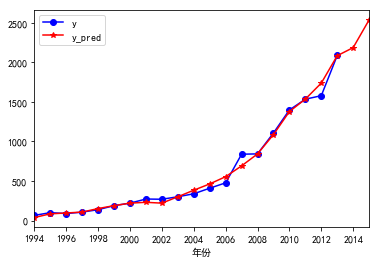

In [19]:
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt

data = pd.read_excel('../tmp/new_reg_data_GM11.xls')  # 读取数据
data = data.drop('Unnamed: 0', axis=1, errors='ignore')  # 如果该列存在则删除，不存在则跳过
data = data.drop(labels='模型精度', axis=0, errors='ignore')  # 删除行
feature = ['x1', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x13']  # 特征所在列
data_train = data.loc[range(1994, 2014)].copy()  # 取2014年前的数据建模
data_mean = data_train.mean()
data_std = data_train.std()
data_train = (data_train - data_mean) / data_std  # 数据标准化
x_train = data_train[feature].as_matrix()  # 特征数据
y_train = data_train['y'].as_matrix()  # 标签数据
linearsvr = LinearSVR(random_state=123)  # 调用LinearSVR()函数
linearsvr.fit(x_train, y_train)

# 预测2014年和2015年财政收入，并还原结果。
x = ((data[feature] - data_mean[feature]) / data_std[feature]).as_matrix()
data[u'y_pred'] = linearsvr.predict(x) * data_std['y'] + data_mean['y']
outputfile = '../tmp/new_reg_data_GM11_revenue.xls'
data.to_excel(outputfile)
print('真实值与预测值分别为：\n', data[['y', 'y_pred']])

print('预测图为：', data[['y', 'y_pred']].plot(style = ['b-o', 'r-*']))  # 画出预测结果图
plt.rcParams['font.sans-serif']=['SimHei']    # 解决中文乱码
plt.xlabel('年份')
plt.xticks(range(1994,2015,2))
plt.show()

## 性能度量

In [17]:
from sklearn.metrics import mean_absolute_error  # 平均绝对误差 
from sklearn.metrics import median_absolute_error  # 中值绝对误差
from sklearn.metrics import explained_variance_score  # 可解释方差
from sklearn.metrics import r2_score  # R方值
import pandas as pd

data = pd.read_excel('../tmp/new_reg_data_GM11_revenue.xls')  # 读取数据
data = data.drop('Unnamed: 0', axis=1, errors='ignore')  # 如果该列存在则删除，不存在则跳过
mean_ab_error = mean_absolute_error(data.loc[range(1994, 2014), 'y'], data.loc[range(1994,2014), 'y_pred'], multioutput = 'raw_values')
median_ab_error = median_absolute_error(data.loc[range(1994, 2014), 'y'], data.loc[range(1994, 2014), 'y_pred'])
explain_var_score = explained_variance_score(data.loc[range(1994, 2014), 'y'], data.loc[range(1994, 2014), 'y_pred'], multioutput = 'raw_values')
r2 = r2_score(data.loc[range(1994, 2014), 'y'], data.loc[range(1994, 2014), 'y_pred'], multioutput = 'raw_values')

print('平均绝对误差：', mean_ab_error, '\n', 
      '中值绝对误差：', median_ab_error, '\n', 
      '可解释方差：', explain_var_score, '\n', 
      'R方值:', r2)

平均绝对误差： [ 34.24652892] 
 中值绝对误差： 17.8079477946 
 可解释方差： [ 0.99086334] 
 R方值: [ 0.99085445]
